In [1]:
import tensorflow as tf

In [131]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

plt.rcParams.update({'font.size': 16})
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.rcParams["figure.figsize"] = (20,10)



In [6]:
filename = "data/gemm2000_shuffled_timeperf_std.txt"
perfs_mean = 96.12746502697733
perfs_std = 23.820358715241372

In [5]:
QUANTILES = [0.15,0.5,0.85]

tf.keras.backend.set_floatx('float64')

class MyModel(tf.keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.d1 = tf.keras.layers.Dense(256, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.00), input_shape=(None,))
    self.d2 = tf.keras.layers.Dense(128, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.00))
    self.d3 = tf.keras.layers.Dense(64, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(0.00))
    self.d4 = tf.keras.layers.Dense(len(QUANTILES), activation='linear', kernel_regularizer=tf.keras.regularizers.l2(0.00))

  def call(self, x):
    x = self.d1(x)
    x = self.d2(x)
    x = self.d3(x)
    return self.d4(x)

# Create an instance of the model
model = MyModel()

In [7]:
model.load_weights('./checkpoints/chp_gemm_square')

In [8]:
def get_quantile_gt(filename,quantile):
    data = {}
    with open(filename) as f:
        lines = f.readlines()
        for line in lines:
            try:
                data[float(line.split()[0])].append(float(line.split()[2]))
            except KeyError:
                data[float(line.split()[0])] = []
                data[float(line.split()[0])].append(float(line.split()[2]))

    for k,v in data.items():
        v.sort()
        
    x_q = []
    y_q = []
    q = int(quantile*100)
    for k,v in data.items():
        x_q.append(k)
        y_q.append(v[q])
        
    return (x_q,y_q)

In [9]:
x_q1, y_q1 = get_quantile_gt(filename,QUANTILES[0])
x_q2, y_q2 = get_quantile_gt(filename,QUANTILES[1])
x_q3, y_q3 = get_quantile_gt(filename,QUANTILES[2])

In [118]:
#sizes = np.arange(10,2110,5)
sizes = np.arange(20,2010,10)
y = []
for s in sizes:
    inp = tf.constant(s,shape=(1,1),dtype="float64")
    y.append((model(inp).numpy()).reshape(-1))
y = np.array(y)

In [127]:
def destd(y):
    y = np.array(y)
    y = y*perfs_std + perfs_mean
    return y

def plot_quantile_compare2(log):
    with open(log) as f:
        lines = f.readlines()
        x = []
        y = []
        for line in lines:
            x.append(float(line.split()[0]))
            y.append(float(line.split()[2]))
            

    #plt.yscale('log')
    #plt.xscale('log')
    #plt.xlabel("size")
    #plt.ylabel("GF/s")
    plt.plot(x,destd(y),'.',color='c')
    #plt.show()

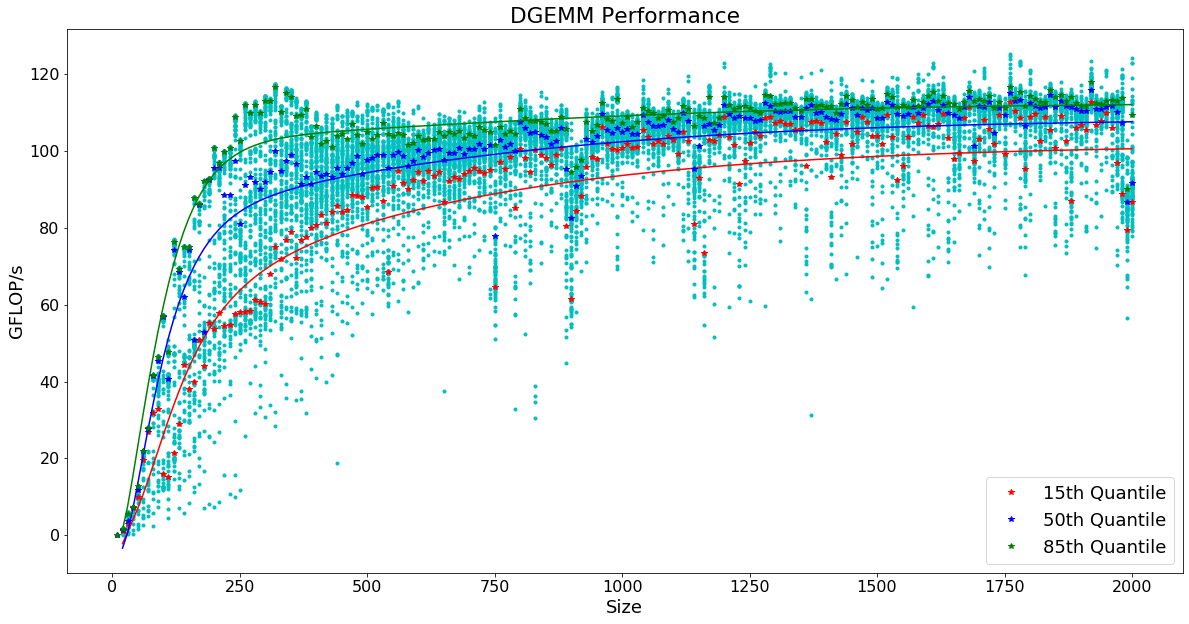

In [139]:
plt.rcParams.update({'font.size': 18})
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 

plt.title("DGEMM Performance")
plt.xlabel("Size")
plt.ylabel("GFLOP/s")
plot_quantile_compare2("data/gemm2000_shuffled_timeperf_std.txt")
plt.plot(sizes,destd(y[:,0]),color='r')
plt.plot(x_q1,destd(y_q1),'*',color='r',label="15th Quantile")
plt.plot(sizes,destd(y[:,1]),color='b')
plt.plot(x_q2,destd(y_q2),'*',color='b' ,label="50th Quantile")
plt.plot(sizes,destd(y[:,2]),color='g')
plt.plot(x_q3,destd(y_q3),'*',color='g',label="85th Quantile")
plt.legend()
plt.show()


In [121]:
def rel_est(x,y,md):
    ym = []   
    for i,j in zip(x,y):
        avg = md[i]
        ym.append((j-avg)/avg)
    return ym

def plot_quantile_compare3(log):
    with open(log) as f:
        lines = f.readlines()
        x = []
        y = []
        for line in lines:
            x.append(float(line.split()[0]))
            y.append(float(line.split()[2]))
    
    y = destd(y)
    a_ = np.array(list(zip(x,y)))
    my_ = {}
    for i in np.unique(x):
        my_[i] = np.mean(a_[np.where(a_[:,0]==i)][:,1])
        
    return [(x,y),my_]


In [122]:
r = plot_quantile_compare3(filename)
x_,y_ = r[0]
md = r[1]

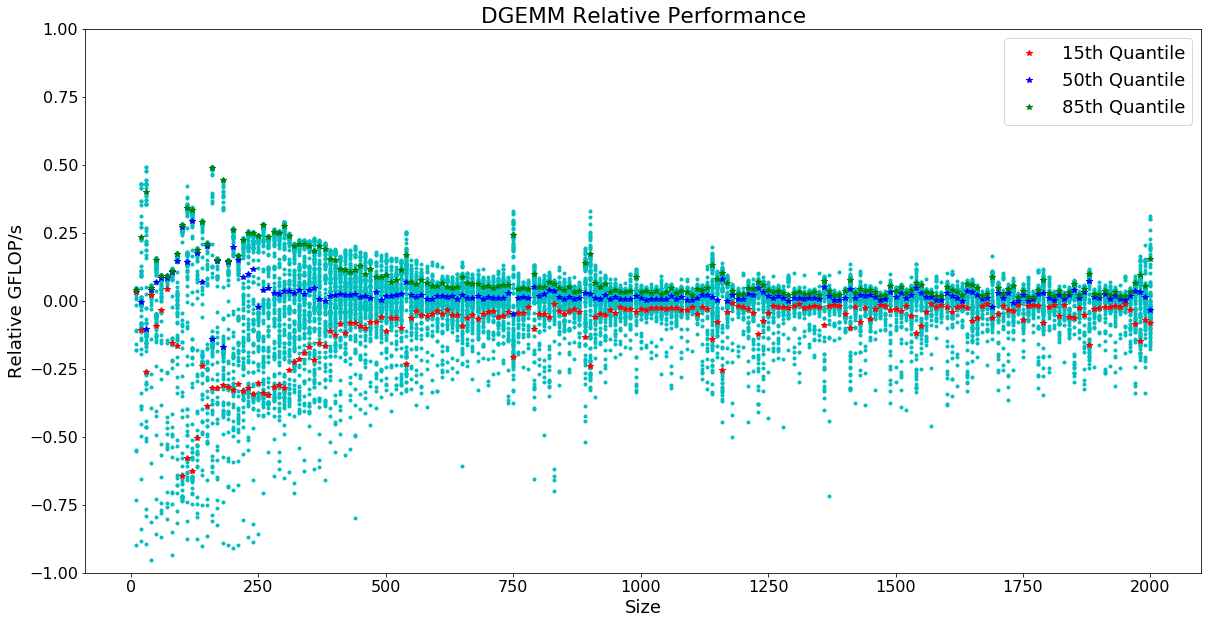

In [138]:
plt.rcParams.update({'font.size': 18})
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 

plt.title("DGEMM Relative Performance")
plt.xlabel("Size")
plt.ylabel("Relative GFLOP/s")

plt.ylim(-1,1)
plt.plot(x_,rel_est(x_,y_,md),'.',color='c')
#plt.plot(sizes,rel_est(sizes,destd(y[:,0]),md),color='r')
#plt.plot(sizes,rel_est(sizes,destd(y[:,1]),md),color='b')
#plt.plot(sizes,rel_est(sizes,destd(y[:,2]),md),color='g')
plt.plot(x_q1,rel_est(x_q1,destd(y_q1),md),'*',color='r',label="15th Quantile")
plt.plot(x_q2,rel_est(x_q2,destd(y_q2),md),'*',color='b',label="50th Quantile")
plt.plot(x_q3,rel_est(x_q3,destd(y_q3),md),'*',color='g',label="85th Quantile")
plt.legend()

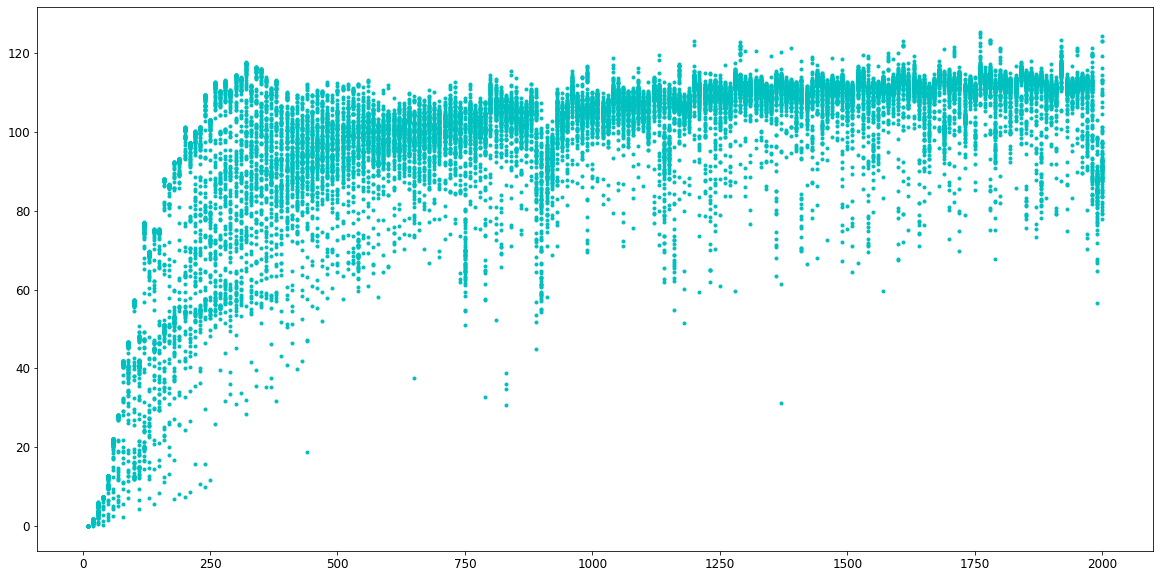

In [104]:
plt.plot(x_,destd(y_),'.',color='c')

In [59]:
x_,y_ = r[0]

In [87]:
xm_ = []
ym_ = []
for i,j in zip(x_,y_):
    xm_.append(i)
    avg = r[1][i]
    ym_.append((j-avg)/avg)

In [66]:
a_[np.where(a_[:,0]==x_[0])][:,1]

array([ 0.46376611,  0.52201703,  0.65229704,  0.56114158,  0.61332336,
        0.69395952,  0.69520311,  0.70744586,  0.76611725,  0.74641009,
        0.62044154,  0.70469665, -0.04750531,  0.66059727,  0.76455861,
        0.60268681,  0.41828543,  0.25655274,  0.6807557 ,  0.69502689,
        0.74631477,  0.55661475,  0.73009132,  0.72786224,  0.63659301,
        0.60395265,  0.5073253 ,  0.73998961, -1.45702113,  0.55529651,
        0.67729651,  0.58900614,  0.58675861,  0.67123459,  0.68767901,
       -0.04172149,  0.77938522,  0.66218111,  0.62301344,  0.63289541,
        0.71012524,  0.70133736,  0.4583904 ,  0.38533496,  0.64406667,
        0.77160189,  0.53048954,  0.56170928,  0.71642378,  0.47984791,
        0.64750772,  0.7494094 ,  0.55558939,  0.71281809,  0.66060748,
        0.56865052, -2.72586475,  0.44214503,  0.78983464,  0.68269342,
        0.69146394,  0.57868754,  0.73148029,  0.71612048,  0.66271271,
        0.46117967,  0.47502733,  1.01438431,  0.67122433,  0.58

In [27]:
a_ = np.array(list(zip(x_,y_)))
a_

array([[1.37000000e+03, 4.63766107e-01],
       [5.80000000e+02, 3.82433205e-03],
       [9.70000000e+02, 3.49309055e-01],
       ...,
       [1.12000000e+03, 6.27847432e-01],
       [5.20000000e+02, 1.10470473e-01],
       [4.10000000e+02, 5.69373903e-02]])

In [40]:
mx_ = []
my_ = []
for i in np.unique(x_):
    mx_.append(i)
    my_.append(np.mean(a_[np.where(a_[:,0]==i)][:,1]))
list(zip(mx_,my_))

[(10.0, -4.02890637371607),
 (20.0, -3.983317346018254),
 (30.0, -3.8668452390785175),
 (40.0, -3.7421451621913593),
 (50.0, -3.57315423462996),
 (60.0, -3.192203631539985),
 (70.0, -2.9596737298357594),
 (80.0, -2.4632104272750324),
 (90.0, -2.3759085579174575),
 (100.0, -2.158444898232341),
 (110.0, -2.5402796162793906),
 (120.0, -1.6309689301898442),
 (130.0, -1.5876342872296618),
 (140.0, -1.5992570415913223),
 (150.0, -1.4374382066135436),
 (160.0, -1.563326478284028),
 (170.0, -0.893233079297692),
 (180.0, -1.3558819431500917),
 (190.0, -0.6409685556652233),
 (200.0, -0.6843785448150137),
 (210.0, -0.5446193696494788),
 (220.0, -0.6205638354586356),
 (230.0, -0.6566643173513078),
 (240.0, -0.3720080369797783),
 (250.0, -0.5547403718808974),
 (260.0, -0.35776957232949086),
 (270.0, -0.2966029580101632),
 (280.0, -0.28170896191446304),
 (290.0, -0.3489089274189458),
 (300.0, -0.31172238187059387),
 (310.0, -0.21027950129165504),
 (320.0, 0.038144988251611174),
 (330.0, -0.205765379

In [38]:
np.unique(x_)

array([  10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,   90.,
        100.,  110.,  120.,  130.,  140.,  150.,  160.,  170.,  180.,
        190.,  200.,  210.,  220.,  230.,  240.,  250.,  260.,  270.,
        280.,  290.,  300.,  310.,  320.,  330.,  340.,  350.,  360.,
        370.,  380.,  390.,  400.,  410.,  420.,  430.,  440.,  450.,
        460.,  470.,  480.,  490.,  500.,  510.,  520.,  530.,  540.,
        550.,  560.,  570.,  580.,  590.,  600.,  610.,  620.,  630.,
        640.,  650.,  660.,  670.,  680.,  690.,  700.,  710.,  720.,
        730.,  740.,  750.,  760.,  770.,  780.,  790.,  800.,  810.,
        820.,  830.,  840.,  850.,  860.,  870.,  880.,  890.,  900.,
        910.,  920.,  930.,  940.,  950.,  960.,  970.,  980.,  990.,
       1000., 1010., 1020., 1030., 1040., 1050., 1060., 1070., 1080.,
       1090., 1100., 1110., 1120., 1130., 1140., 1150., 1160., 1170.,
       1180., 1190., 1200., 1210., 1220., 1230., 1240., 1250., 1260.,
       1270., 1280.,

In [80]:
np.array(r[1])[np.where(np.array(r[1])[:,0]==10.0)]

array([[10.        , -4.02890637]])

In [86]:
r[1]

{10.0: -4.02890637371607,
 20.0: -3.983317346018254,
 30.0: -3.8668452390785175,
 40.0: -3.7421451621913593,
 50.0: -3.57315423462996,
 60.0: -3.192203631539985,
 70.0: -2.9596737298357594,
 80.0: -2.4632104272750324,
 90.0: -2.3759085579174575,
 100.0: -2.158444898232341,
 110.0: -2.5402796162793906,
 120.0: -1.6309689301898442,
 130.0: -1.5876342872296618,
 140.0: -1.5992570415913223,
 150.0: -1.4374382066135436,
 160.0: -1.563326478284028,
 170.0: -0.893233079297692,
 180.0: -1.3558819431500917,
 190.0: -0.6409685556652233,
 200.0: -0.6843785448150137,
 210.0: -0.5446193696494788,
 220.0: -0.6205638354586356,
 230.0: -0.6566643173513078,
 240.0: -0.3720080369797783,
 250.0: -0.5547403718808974,
 260.0: -0.35776957232949086,
 270.0: -0.2966029580101632,
 280.0: -0.28170896191446304,
 290.0: -0.3489089274189458,
 300.0: -0.31172238187059387,
 310.0: -0.21027950129165504,
 320.0: 0.038144988251611174,
 330.0: -0.20576537990112317,
 340.0: -0.040693625572201804,
 350.0: -0.0487336101034

In [113]:
np.arange(10,2010,10)

array([  10,   20,   30,   40,   50,   60,   70,   80,   90,  100,  110,
        120,  130,  140,  150,  160,  170,  180,  190,  200,  210,  220,
        230,  240,  250,  260,  270,  280,  290,  300,  310,  320,  330,
        340,  350,  360,  370,  380,  390,  400,  410,  420,  430,  440,
        450,  460,  470,  480,  490,  500,  510,  520,  530,  540,  550,
        560,  570,  580,  590,  600,  610,  620,  630,  640,  650,  660,
        670,  680,  690,  700,  710,  720,  730,  740,  750,  760,  770,
        780,  790,  800,  810,  820,  830,  840,  850,  860,  870,  880,
        890,  900,  910,  920,  930,  940,  950,  960,  970,  980,  990,
       1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1100,
       1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200, 1210,
       1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300, 1310, 1320,
       1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420, 1430,
       1440, 1450, 1460, 1470, 1480, 1490, 1500, 15